# Solving shortest path problem using ACO

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from haversine import haversine
import networkx as nx
import matplotlib.pyplot as plt
import random

### Define the shorest path problem

In [2]:
# Define latitude and longitude for twenty major U.S. cities
cities = {
    'New York City': (40.72, -74.00),
    'Philadelphia': (39.95, -75.17),       
    'Baltimore': (39.28, -76.62),
    'Charlotte': (35.23, -80.85),
    'Memphis': (35.12, -89.97),
    'Jacksonville': (30.32, -81.70),
    'Houston': (29.77, -95.38),
    'Austin': (30.27, -97.77),
    'San Antonio': (29.53, -98.47),
    'Fort Worth': (32.75, -97.33),
    'Dallas': (32.78, -96.80),
    'San Diego': (32.78, -117.15),
    'Los Angeles': (34.05, -118.25),
    'San Jose': (37.30, -121.87),
    'San Francisco': (37.78, -122.42),    
    'Indianapolis': (39.78, -86.15),
    'Phoenix': (33.45, -112.07),       
    'Columbus': (39.98, -82.98), 
    'Chicago': (41.88, -87.63),
    'Detroit': (42.33, -83.05)
}

# Create a haversine distance matrix based on latitude-longitude coordinates
distance_matrix = defaultdict(dict)
for ka, va in cities.items():
    for kb, vb in cities.items():
        distance_matrix[ka][kb] = 0.0 if kb == ka else haversine((va[0], va[1]), (vb[0], vb[1])) 

# Convert distance diccionary into a dataframe        
distances = pd.DataFrame(distance_matrix)

city_names=list(distances.columns)    
distances=distances.values  
city_count = len(city_names)

### Visualize the shorest path problem

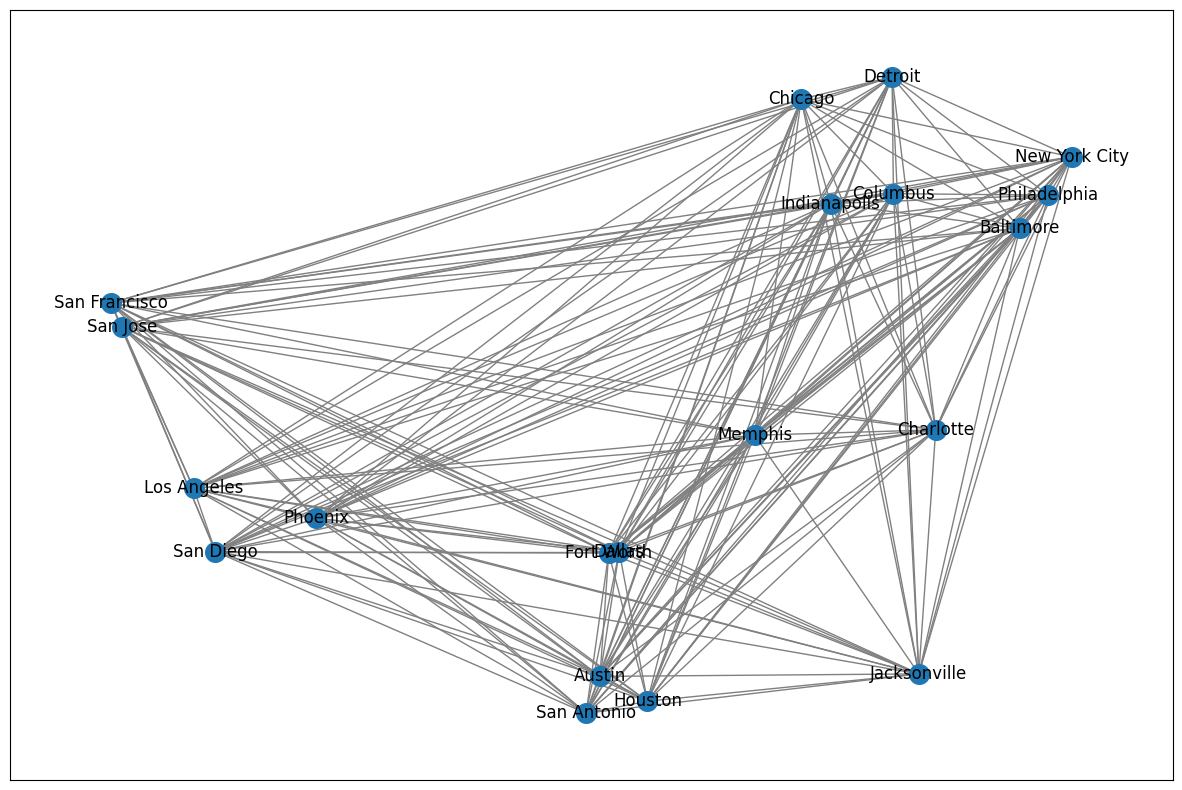

In [3]:
# Create a graph
G=nx.Graph()

for ka, va in cities.items():
    for kb, vb in cities.items():
        G.add_weighted_edges_from({(ka,kb, distance_matrix[ka][kb])})
        G.remove_edges_from(nx.selfloop_edges(G))
        
fig, ax = plt.subplots(figsize=(15,10))

# Reverse lat and long for correct visualization
reversed_dict = {key: value[::-1] for key, value in cities.items()}

# Create an independent shallow copy of the graph and attributes
H = G.copy()
 
# Draw the network
ax=nx.draw_networkx(
    H,
    pos=reversed_dict,
    with_labels=True,
    edge_color="gray",
    node_size=200,
    width=1,
)

plt.show()
# plt.savefig('CH08_F15_TSP.png', format='png', dpi=300)

### Define cost function

In [4]:
def cost_function(path, distances):
    path_distance = 0
    for i in range(len(path) - 1):
        path_distance += distances[path[i], path[i+1]]
    return path_distance

### Create ACO solver class

In [5]:
class ACO:
    def __init__(self, ants, iterations, alpha, beta, evaporation_rate, Q, distances):
        self.ants = ants
        self.iterations = iterations
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.Q = Q
        self.distances = distances
        self.city_count = len(distances)
        self.pheromones = np.ones((self.city_count, self.city_count))

    def _update_pheromones(self, paths, distances):
        delta_pheromones = np.zeros((self.city_count, self.city_count))

        for i in range(self.ants):
            for j in range(self.city_count - 1):
                delta_pheromones[paths[i, j], paths[i, j+1]] += self.Q / distances[i]
            delta_pheromones[paths[i, -1], paths[i, 0]] += self.Q / distances[i]

        self.pheromones = (1 - self.evaporation_rate) * self.pheromones + delta_pheromones

    def run(self):
        best_path = None
        best_distance = float('inf')

        for _ in range(self.iterations):
            paths = np.empty((self.ants, self.city_count), dtype=int)

            for ant in range(self.ants):
                path = [0]
                unvisited_cities = list(range(1, self.city_count))

                while unvisited_cities:
                    current_city = path[-1]
                    probabilities = []

                    for city in unvisited_cities:
                        tau = self.pheromones[current_city, city] ** self.alpha
                        eta = (1 / self.distances[current_city, city]) ** self.beta
                        probabilities.append(tau * eta)

                    probabilities /= sum(probabilities)
                    next_city = random.choices(unvisited_cities, weights=probabilities)[0]

                    unvisited_cities.remove(next_city)
                    path.append(next_city)

                paths[ant] = path

            distances = np.array([cost_function(path, self.distances) for path in paths])
            min_idx = distances.argmin()
            min_distance = distances[min_idx]

            if min_distance < best_distance:
                best_distance = min_distance
                best_path = paths[min_idx]

            self._update_pheromones(paths, distances)

        return best_path, best_distance

### Set up the parameters and apply the solver

In [6]:
# ACO parameters
ants = 30
iterations = 100
alpha = 1
beta = 0.9
evaporation_rate = 0.5
Q = 100

# Instantiate ACO with required parameters
aco = ACO(ants, iterations, alpha, beta, evaporation_rate, Q, distances)

# Call optimize method on the ACO instance
best_path, best_distance = aco.run()

### Print the results

In [7]:
city_names_tour=[city_names[i] for i in best_path]
Route = " → ".join(city_names_tour)
print("Route:", Route)
print("Route length:", np.round(best_distance, 3))

Route: New York City → Philadelphia → Baltimore → Columbus → Detroit → Chicago → Indianapolis → Charlotte → Jacksonville → Memphis → Fort Worth → Dallas → Houston → San Antonio → Austin → Phoenix → San Diego → Los Angeles → San Jose → San Francisco
Route length: 8064.783


### Visualize the obtained route

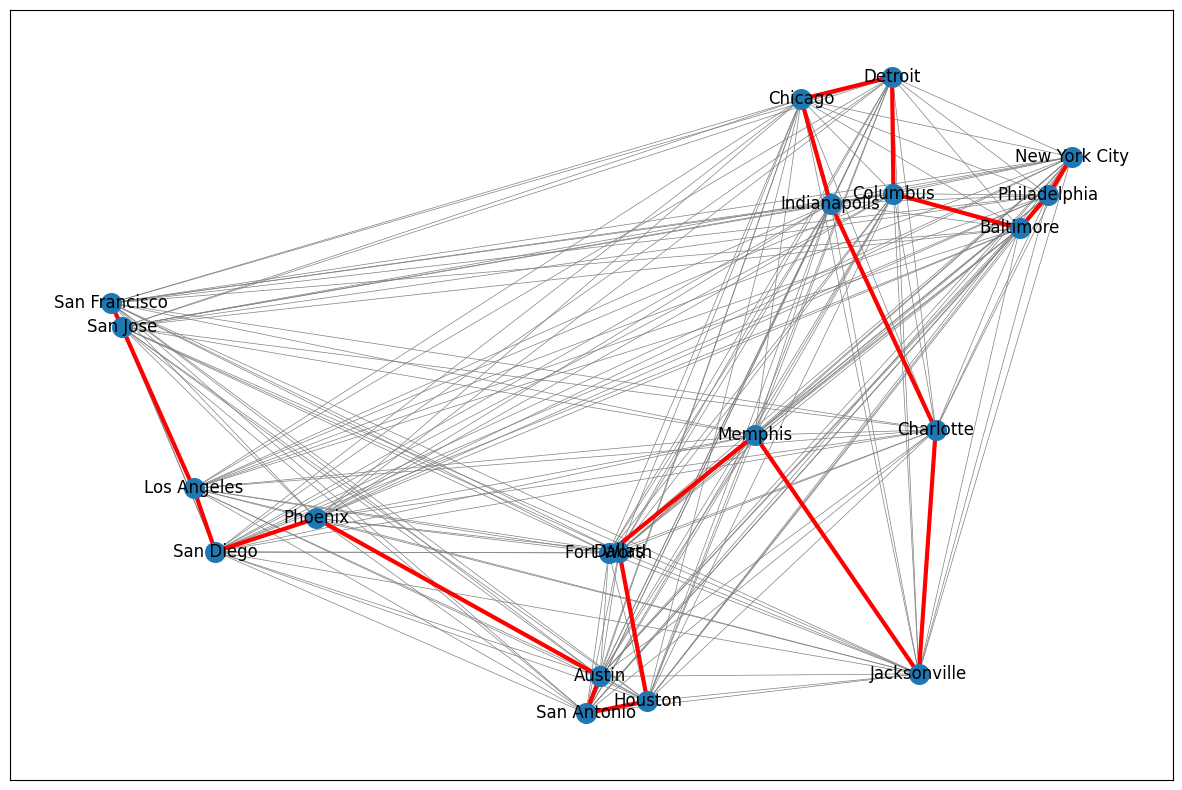

In [14]:
fig, ax = plt.subplots(figsize=(15,10))

# Create an independent shallow copy of the graph and attributes
H = G.copy()

# Reverse lat and long for correct visualization
reversed_dict = {key: value[::-1] for key, value in cities.items()}

# Create edge list
edge_list =list(nx.utils.pairwise(city_names_tour))

# Draw closest edges on each node only
nx.draw_networkx_edges(H, pos=reversed_dict, edge_color="gray", width=0.5)

# Draw the route
ax=nx.draw_networkx(
    H,
    pos=reversed_dict,
    with_labels=True,
    edgelist=edge_list,
    edge_color="red",
    node_size=200,
    width=3,
)

plt.show()

# Solving TSP using ACOpy

In [9]:
# !pip install acopy

In [10]:
import acopy
import networkx as nx

G=nx.Graph()

for ka, va in cities.items():
    for kb, vb in cities.items():
        G.add_weighted_edges_from({(ka,kb, distance_matrix[ka][kb])})
        G.remove_edges_from(nx.selfloop_edges(G))

# ACO parameters
evaporation_rate = 0.5
iterations = 100
Q = 100

# Set up the ACO solver
solver = acopy.Solver(rho=evaporation_rate, q=Q)

# Set up the ACO colony with alpha and beta parameters
colony = acopy.Colony(alpha=1, beta=5)

# Run the ACO algorithm
n_iter = 0
while n_iter < iterations:
    tour = solver.solve(G, colony, limit=4)
    path_indices = ['New York City']  # Start with City 0 (New York City) 
    for edge in tour.path:
        # Add the other node from the edge that is not already in the path
        next_city = edge[0] if edge[1] == path_indices[-1] else edge[1]
        if next_city not in path_indices:
            path_indices.append(next_city)
    # # path_indices.append(0)  # Close the loop by adding City 0 again in case of TSP
    # if len(set(path_indices)) == len(cities) + 1:
    #     break
    n_iter += 1

tour.path=path_indices

### Print the results

In [11]:
# Print the best solution
best_path = tour.path
best_distance = tour.cost
Route = " → ".join(best_path)
print("Route:", Route)
print("Route length:", np.round(best_distance, 3))

Route: New York City → Indianapolis → Columbus → Detroit → Philadelphia → Baltimore → Charlotte → Jacksonville → Memphis → Dallas → Fort Worth → Austin → Houston → San Antonio → Phoenix → San Diego → Los Angeles → San Jose → San Francisco → Chicago
Route length: 11027.413


### Visualize the obtained route

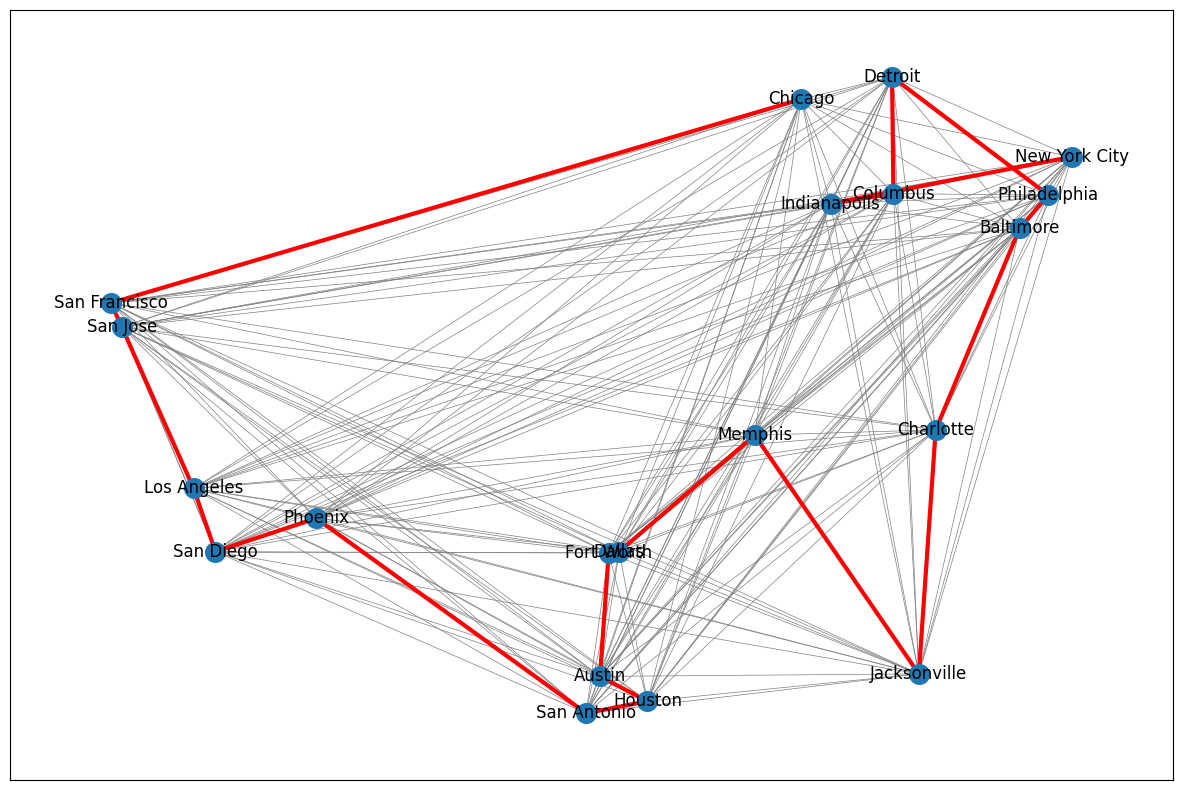

In [13]:
fig, ax = plt.subplots(figsize=(15,10))

# Create an independent shallow copy of the graph and attributes
H = G.copy()

# Reverse lat and long for correct visualization
reversed_dict = {key: value[::-1] for key, value in cities.items()}

# Create edge list
edge_list =list(nx.utils.pairwise(best_path))

# Draw closest edges on each node only
nx.draw_networkx_edges(H, pos=reversed_dict, edge_color="gray", width=0.5)

# Draw the route
ax=nx.draw_networkx(
    H,
    pos=reversed_dict,
    with_labels=True,
    edgelist=edge_list,
    edge_color="red",
    node_size=200,
    width=3,
)

plt.show()